In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "8,3"

# Aliasing and Anti-Aliasing Filters

In this article we will explain the effect of aliasing, why it occurs and what can be done against it. Aliasing can occur whenever a sample rate conversion or sampling of an analog signal is performed. Great care needs to be taken to inhibit aliasing, as otherwise the resulting signal can be severely degraded. 

To motivate this, let us listen to the effect of aliasing for three different kinds of signals. We take an original audio signal and perform a downsampling operation, for example to save bandwidth. Naturally, higher frequencies in the signal cannot be represented accurately with a too low sampling rate, so the downsampled audio does not sound as "bright" as the original. Despite, the effect of aliasing even impedes the audio quality. For each signal, first the original signal is presented, followed by a downsampled version that contains aliasing. Finally, the downsampled audio that has been sent through an anti-aliasing filter to prevent aliasing is provided. 

> A speech signal (taken from [LibriVox](https://librivox.org/the-adventures-of-a-dog-and-a-good-dog-too-by-alfred-elwes/)). Here, aliasing manifests itself as some extra noise, especially around characters like 's' and 'z'.

In [12]:
# to call this function, the code below needs to be executed before
presentAliasingAudio(data_voice, rate_voice, 6)

> A piece of classical music. Here, the aliasing occurs as some extra high-frequency tones that do not belong to the original recording.

In [13]:
presentAliasingAudio(data_music, rate_music, 6)

> Finally, consider an artificial signal, consisting of a chirp, i.e. a signal whose instantaneous frequency grows with time. Here, the aliasing shows up as a decrease in frequency once a particular frequency has been reached. When aliasing was removed by the anti-aliasing filter, this effect is almost completely removed and the signal just remains silent for higher frequencies.

In [14]:
Fs = 44100
t = np.arange(0, 10, 1/Fs)
f = 200
data_chirp = np.sin(2*np.pi*f*t*t)
rate_chirp = Fs
presentAliasingAudio(data_chirp, rate_chirp, 10)

Let us now try to explain what aliasing actually is and how we can understand it: 

The word *aliasing* arises from the fact, that two different sine waves with frequencies $f_0, f_1$ generate the same samples, when $f_1=f_0+F_s$, where $F_s$ is the sampling frequency. I.e., from a sequence of samples of a sine wave it is impossible to tell, what the frequency of the original sine wave was. The sampling is ambiguous, and two different frequencies $f_0,f_1$ are mapped to the same sampling points. 

We can show this in a simple form: Assume we have a function $x_0(t)=\sin(2\pi f_0 t)$ and a function $x_1(t)=\sin(2\pi (f_0+F_s)t)$ and we sample both signals with the sampling frequency $F_s$:

$$
\begin{align}
x_1[n] &= \sin\left(2\pi f_0 \frac{n}{F_s}\right)\\
x_2[n] &= \sin\left(2\pi (f_0+F_s)\frac{n}{F_s}\right)\\&=\sin\left(2\pi f_0\frac{n}{F_s}+2\pi n\right)=\sin(2\pi f_0\frac{n}{F_s})=x_1[n]
\end{align}
$$

As we see, both signals would create the same samples. We can also show another property, namely, that two sine waves of frequencies $f_0$ and $f_1=F_s-f_0$ also create the same samples up to a sign change:

$$
\begin{align}
x_1[n] &= \sin\left(2\pi f_0 \frac{n}{F_s}\right)\\
x_2[n] &= \sin\left(2\pi (F_s-f_0)\frac{n}{F_s}\right)\\
&=\sin\left(-2\pi f_0\frac{n}{F_s}+2\pi n\right)=-x_1[n]
\end{align}
$$

I.e. also the frequencies $f_0$ and $F_s-f_0$ correspond to the same sampling points. 

> To summarize, sine waves of frequencies $\pm f_0+nF_s, n\in\mathbb{Z}$ all create the same sampling points when sampled with sampling frequency $F_s$. Hence, when a sampled sequence appears to correspond to a sine wave with frequency $f_0$, it could also have been obtained from a sine wave with frequency $f_0+nF_s$ or $nF_s-f_0$. This effect, i.e. the **mapping of different frequencies to the same sampling points**, is called **aliasing**.

Let us look at this effect numerically. In the following, we create a sine wave of a given frequency $f_1$ and sample it with sampling frequency $F_s=5Hz$. Also, we draw one corresponding aliasing frequency to show that both sine waves would create the same sample points. Additionally, we plot the spectrum of the original signal and the aliased version.

In [15]:
Fs = 5      # the sampling frequency
F_plot = 100  # the frequency used for plotting the time-continuous curves
T = 2       # the time-span we'll cover
t = np.arange(0, T, 1/Fs)  # the sample times
t_plot = np.arange(0, t.max(), 1/F_plot)  # time instants for plotting


def showAlias(f1):
    plt.gcf().clear()
    f2 = min(f1, Fs-f1)  # determine the alias frequency
    xt1 = lambda t: np.cos(2*np.pi*f1*t) # create both sine-functions
    xt2 = lambda t: np.cos(2*np.pi*f2*t)
    
    # plot the signals
    plt.subplot(121)
    plt.plot(t_plot, xt1(t_plot), 'b-', lw=2, label='input signal')
    plt.stem(t, xt1(t), label='sampled points')
    plt.plot(t_plot, xt2(t_plot), 'g-', label='after sampling')
    plt.ylim((-1.1, 1.5)); plt.grid(True)
    plt.legend(fontsize=8)
    plt.xlabel('$t$'); plt.ylabel('$x(t), x[n]$')
    
    # plot the spectrum of the signals
    t_freq = np.arange(0, 20*T, 1/F_plot) 
    x1 = xt1(t_freq)
    x2 = xt2(t_freq)
    X1 = np.fft.fftshift(np.fft.fft(x1, 8*len(x1))) / len(x1)
    X2 = np.fft.fftshift(np.fft.fft(x2, 8*len(x1))) / len(x2)
    f = np.linspace(-F_plot/2, F_plot/2, len(X1), endpoint=False)
    plt.subplot(122)
    plt.plot(f, abs(X1), lw=2, label='input')
    plt.plot(f, abs(X2), label='after sampling')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlim((-Fs, Fs))
    plt.axvline(-Fs/2, color='k', ls='--', lw=2)
    plt.axvline(Fs/2, color='k', ls='--', lw=2)
    plt.ylim((-0.1, 1.1))
    plt.grid(True)
    plt.text(x=2.5, y=0.8, s='$f_{in}=%.2f$\n$f_{out}=%.2f$' % (f1, f2), bbox=dict(facecolor='white'))
    plt.xlabel('$f$'); plt.ylabel('$|X(f)|$')
    plt.show()

In [16]:
plt.figure()
interact(showAlias, f1=(0,5., 0.01));

In the left figure, the time-domain input signal (blue) with frequency $f_0$, the sampled points (blue dots) and the sine wave with the same sampling points but with frequency $0<f_1<F_s/2$ (green) are shown. In the right figure, the spectrum of both sine-waves is presented. As long as the input signal in blue is within $0<f_0<F_s/2$, the green curve is on top of the blue. But, as soon as $f_0>Fs/2$, the frequency of the green curve decreases, when the input frequency increases. **The input signal of too high frequency $f_0>F_s/2$ is mapped to a lower frequency $F_s-f_0$ in the output**. 

This is also exactly what we heard in the third sound example of aliasing, i.e. the chirp function.  As soon, as the frequency of the sine went above the Nyquist frequency, the aliasing kicks in and the actually played frequencie decreases. Let us repeat this here for convenience:

In [17]:
presentAliasingAudio(data_chirp, rate_chirp, 10)

## Anti-Aliasing Filter

As we have seen, when sampling a signal that contains frequencies that are above half of the sampling frequency, the sampling maps these to some other frequencies within the Nyquist frequency. These so-called *image frequencies* or *alias frequencies* are often unwanted, since they do not represent the original signal. Instead, one uses an anti-aliasing filter (AAF) to filter the input signal before sampling. 

The anti-aliasing filter is basically a low-pass filter with (ideal) cutoff frequency of $F_s/2$. Hence, it blocks all frequencies that would create images in the sampled signal, before sampling the signal. Accordingly, there is a loss in the information about high frequencies when applying the anti-aliasing filter. However, the same loss would again be incurred when sampling the signal with frequency $F_s/2$, since the output frequencies cannot be unambiguously mapped to the input frequencies due to the aliasing effect. 


For our purposes, we design a simple FIR lowpass filter as the anti-aliasing filter. Given a downsampling factor of value `factor`, the low-pass filter needs to filter all frequencies above $\frac{F_s}{2\text{factor}}$. We add a litte bit of headroom to the cutoff, i.e. we design the cutoff frequencies to be at $\frac{F_s}{2\text{factor}}-0.01$ to accomodate the non-ideal filter flank. Note that the designed filter of length 155 samples has a rather long [group delay](http://dspillustrations.com/pages/posts/misc/group-delay-and-phase-delay-example.html), i.e. it introduces considerable delay of roughly $155/2$ samples, which might not be acceptable depending on the actual application. In audio, we do not care too much about the group delay, so it's fine for us here. In particular, we use a FIR filter to achieve linear-phase and hence a constant [group delay](http://dspillustrations.com/pages/posts/misc/group-delay-and-phase-delay-example.html), which is useful to not distort the sound too much.

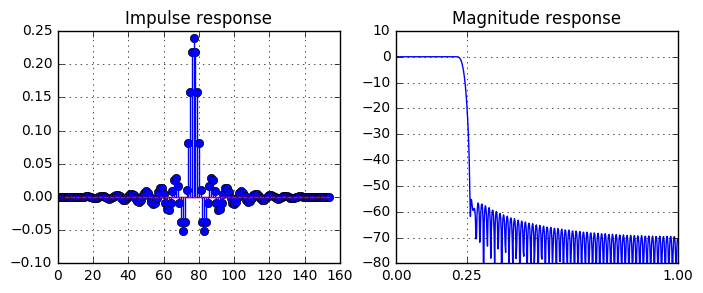

In [18]:
factor = 4  # the downsampling factor
b = signal.firwin(155, 1.0/factor-0.01); a=1  # design the filter
w, H = signal.freqz(b, a) # calculate frequency response

plt.subplot(121)
plt.stem(b)
plt.grid(True); plt.title('Impulse response')

plt.subplot(122)
plt.plot(w/np.pi, 20*np.log10(abs(H)))
plt.grid(True)
plt.xticks([0, 1/factor, 1]);
plt.ylim((-80, 10)); plt.title("Magnitude response");

Now, with the designed anti-aliasing filter, we can go ahead and implement our downsampling with and without anti-aliasing filtering:

In [19]:
def presentAliasingAudio(original, rate, factor):
    down_aliased = original[::factor] # dumb downsampling, no anti-aliasing

    b = signal.firwin(155, 1.0/factor-0.01); a=1  # design the AAF
    lowpass = signal.lfilter(b, a, original)      # apply the AAF
    down_nonaliased = lowpass[::factor]           # perform Downsampling

    display(HTML("Original:"), Audio(data=original, rate=rate))
    display(HTML("With Aliasing:"), Audio(data=down_aliased, rate=rate/factor))
    display(HTML("Without Aliasing:"), Audio(data=down_nonaliased,rate=rate/factor))

Finally, here's the code to load the presented audio pieces from the internet:

In [20]:
def loadAudio(url, start, length):
    R = requests.get(url)
    with open("sound.mp3", "wb") as f:
        f.write(R.content)
    !ffmpeg -y -i sound.mp3 sound.wav > /dev/null
    rate, data = wavfile.read("sound.wav")
    if len(data.shape) > 1:
        data = data.sum(axis=1)
    data = (1.0 * data / abs(data).max()).astype(np.float32)
    
    return rate, data[rate*start+np.arange(rate*length)]

And eventually, the URLs and calls to actually load the audio from the WWW:

In [ ]:
url_voice = "http://ia800200.us.archive.org/21/items/adventures_of_dog_1101_librivox/adventuresofadog_00_elwes.mp3"
url_music = "http://www.scientificinvesting.eu/a/Mozart%20-%20Symphony%20n.10%20K.74%20in%20G%20-%201%20Allegro.mp3"
rate_voice, data_voice = loadAudio(url_voice, 40, 10)
rate_music, data_music = loadAudio(url_music, 40, 10)

## Summary

> - Aliasing occurs during downsampling a digital or sampling an analog signal
> - The name *Aliasing* stems from the fact that several different frequencies on the original signal are mapped to the same sampled sequence, i.e. creating ambiguity in the sampled signal.
> - Aliasing can be mitigated by application of a low-pass filter before downsampling. The low-pass filter removes all frequencies above half the Nyquist-frequency and thus inhibits aliasing of high-frequencies into the lower frequencies. 
> - In audio, aliasing can have different sounds, depending on the originating signal. 